# Lab 2 : Sentiment analysis, a Text Classification Task

In [ ]:
!pip install gdown
import random
import numpy as np
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

!gdown --id 12Jv1GpSBRCItwxP8LXBXDhOAow609IUP # Dowload a SentimentCSV file

# we fix the seeds to get consistent results before every training loop in what follows
def fix_seed(seed=234):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
fix_seed()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12Jv1GpSBRCItwxP8LXBXDhOAow609IUP
To: /content/sentiment_sentences.csv
100% 735/735 [00:00<00:00, 1.10MB/s]


## About this lab

In this notebook, we are going to build state-of-the art models for text classification using the example of sentiment analysis. To be more precise, we will build a feed-forward neural network (FFNN) and a convolutional neural network (CNN). We will look into the details of data preparation, functioning of each model and how the performance of those NNs could be measured efficiently. We will start our work using a toy corpus. Further you can extend your knowledge and use a larger dataset. Again we are using [pytorch](https://www.pytorch.org), an open source deep learning platform, as our backbone library in the course.

Goal of this lab :
* Preprocess some Text Dataset
* Train models for NLP

## Toying Around 


First, we present to you our toy dataset, composed of a toy training and validation sets. It is good practise to use the validation set (a representative set of the test data). This set is used to tune hyperparameters and choose a configuration for your model to ensure the best performance. Our toy sets are already tokenized and lowercased.

* What is 1 ? What is 0 ?

1 for positive feedback, and 0 for the negative one 

In [ ]:
 # Our toy sentiment analysis corpus
train = ['i like his new book !',
         'what a well-written novel !',
         'i do not agree with the criticism on this short story',
         'well done ! it was an enjoyable stage play',
         'it was very good . send me a copy please .',
         'the argumentation in the study is very weak',
         'poor effort !',
         'the descriptions could have been more detailed',
         'i am not impressed',
         'could have done better .',
]

train_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

# Validation set
valid = ['i like your play', 
         'i agree with your study', 
         'what a success ! a well-written novel', 
         'not enough details . very poor', 
         'i support the criticism',
         'could be better',
]

valid_labels = [1, 1, 1, 0, 0, 0]

### Pre-processing

* Using simple list operators, fill in the below function '...' to **tokenize the corpus.** 

Hint : a Token could correspond to a word, punctuation...

In [ ]:
def get_tokenized_corpus(corpus):
  tokenized_corpus = []

  #######################
  # Q: Process the corpus
  #######################
  for sentence in corpus:
    tokenized_sentence = []
    for token in sentence.split(' '): 
      tokenized_sentence.append(token)
    tokenized_corpus.append(tokenized_sentence)
 
  return tokenized_corpus

### Word2index dictionary

In order to easily retrieve each word in the vocabulary, we define here a method that returns a word to index dictionary. 

**Note** : we reserve the 0 index for the padding token `<pad>`.

In [ ]:
def get_word2idx(tokenized_corpus):
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
  
  word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
  # we reserve the 0 index for the padding token
  word2idx['<pad>'] = 0
  
 
  return word2idx

tokenized_corpus = get_tokenized_corpus(train)
print(tokenized_corpus)
word2idx = get_word2idx(tokenized_corpus)

print(word2idx)
print(len(word2idx))

[['i', 'like', 'his', 'new', 'book', '!'], ['what', 'a', 'well-written', 'novel', '!'], ['i', 'do', 'not', 'agree', 'with', 'the', 'criticism', 'on', 'this', 'short', 'story'], ['well', 'done', '!', 'it', 'was', 'an', 'enjoyable', 'stage', 'play'], ['it', 'was', 'very', 'good', '.', 'send', 'me', 'a', 'copy', 'please', '.'], ['the', 'argumentation', 'in', 'the', 'study', 'is', 'very', 'weak'], ['poor', 'effort', '!'], ['the', 'descriptions', 'could', 'have', 'been', 'more', 'detailed'], ['i', 'am', 'not', 'impressed'], ['could', 'have', 'done', 'better', '.']]
{'i': 1, 'like': 2, 'his': 3, 'new': 4, 'book': 5, '!': 6, 'what': 7, 'a': 8, 'well-written': 9, 'novel': 10, 'do': 11, 'not': 12, 'agree': 13, 'with': 14, 'the': 15, 'criticism': 16, 'on': 17, 'this': 18, 'short': 19, 'story': 20, 'well': 21, 'done': 22, 'it': 23, 'was': 24, 'an': 25, 'enjoyable': 26, 'stage': 27, 'play': 28, 'very': 29, 'good': 30, '.': 31, 'send': 32, 'me': 33, 'copy': 34, 'please': 35, 'argumentation': 36, 'i

### Preparation of the inputs

We will first train a FFN (Feed Forward Network). The first layer of our FFN will be an embedding (look-up) layer which takes as input indexes of tokens (we do not need to one-hot encode our vectors).

---

**Q: Why do we need to fix the length of our input vectors (we take the maximum sentence length here) ? This process is referred to as padding. Print the padded training corpus.**

In [ ]:
def get_model_inputs(tokenized_corpus, word2idx, labels):
  # we index our sentences
  vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]

  # Sentence lengths
  sent_lengths = [len(sent) for sent in vectorized_sents]

  # TODO : Get maximum length
  max_len = max(sent_lengths)
  
  # we create a tensor of a fixed size filled with zeroes for padding
  sent_tensor = torch.zeros((len(vectorized_sents), max_len)).long()

  # we fill it with our vectorized sentences 
  for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):
    sent_tensor[idx, :sentlen] = torch.LongTensor(sent)

  # TODO : Label tensor
  label_tensor = torch.FloatTensor(labels)
  
  return sent_tensor, label_tensor

### TODO : Test your functions

tokenized_corpus = get_tokenized_corpus(train)
word2idx = get_word2idx(tokenized_corpus)
train_sent_tensor, train_label_tensor = get_model_inputs(tokenized_corpus, word2idx, train_labels)

print(train_sent_tensor)
print(train_label_tensor)

tensor([[ 1,  2,  3,  4,  5,  6,  0,  0,  0,  0,  0],
        [ 7,  8,  9, 10,  6,  0,  0,  0,  0,  0,  0],
        [ 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        [21, 22,  6, 23, 24, 25, 26, 27, 28,  0,  0],
        [23, 24, 29, 30, 31, 32, 33,  8, 34, 35, 31],
        [15, 36, 37, 15, 38, 39, 29, 40,  0,  0,  0],
        [41, 42,  6,  0,  0,  0,  0,  0,  0,  0,  0],
        [15, 43, 44, 45, 46, 47, 48,  0,  0,  0,  0],
        [ 1, 49, 12, 50,  0,  0,  0,  0,  0,  0,  0],
        [44, 45, 22, 51, 31,  0,  0,  0,  0,  0,  0]])
tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])


### Data visualization 


#### Existing CSV File

* Go to your workspace by clicking on the folder icon on the left of your notebook and click on the sentimen_sentences.csv file
* What do you see ? Explain the Dataset

In order to have insight about what embeddings look like, use https://huggingface.co/spaces/mohitmayank/sentenceviz with the sentiment_sentences CSV file available on the github or in your google colab workspace. You just have to download it and load it in the website to vizualise your embeddings.



---

**Q:** 
* **What changes can you see between the different embeddings visualization techniques ?**
* **What can you infer from these differences ?**

#### Creating our own corpus

Now you can try to visualize embeddings of our corpus using the csv module to convert the list of word into a CSV file matching the one you already used. 

* Create a CSV File based on our corpus and perform the same data visualization
---

**Q: What differences do you notice ?**

In [ ]:
# define the name of the CSV file
filename = "corpus_sentences.csv"

# open the CSV file in write mode
with open(filename, 'w', newline='') as file:

    # create a CSV writer object
    writer = csv.writer(file)
    writer.writerow(['text','class'])#specify the header 

    # write in the CSV file
    for sentence,l in zip(train,train_labels) :
        
        if l == 0:
          writer.writerow([sentence,'Negative']) 
        else:
          writer.writerow([sentence,'Positive']) 
    
        # Hint : https://docs.python.org/3/library/csv.html

**sentiment_sentences**
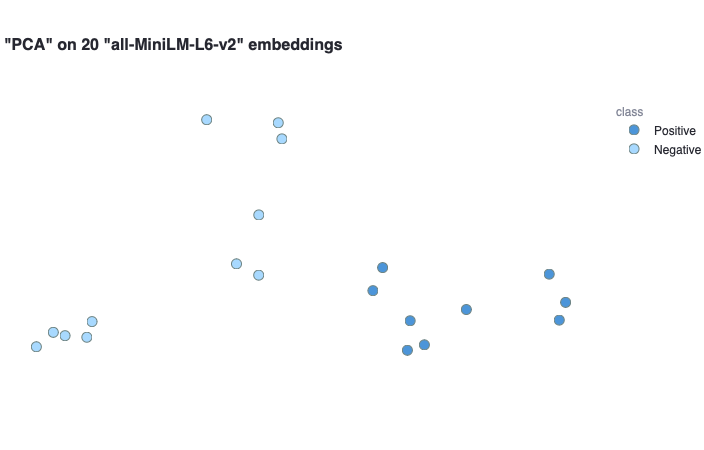


**corpus_sentences**
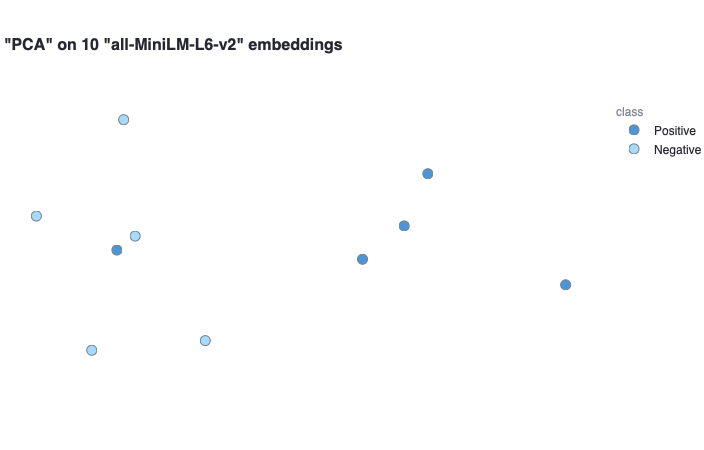

## Model 1 : the Feed-Forward Network

We will start by building a very simple feed-forward neural network (FFNN).
Our FFNN class is a sub-class of `nn.Module`. Within the `__init__` method, we define the layers of the module:

- Our first layer is an embedding layer (look-up layer). This layer could be initialized with pre-trained embeddings (as we will see at the end of this lab) or could be trained together with other layers.
 
- The next layer is a fully connected layer followed by a ReLU activation.

- Finally, the last linear layer is the output layer for the classification task.

The `forward()` method is called when we feed data into our model. Please note that the output dimension of each layer is the input dimension for the next one.

---


**Q: Implement the averaging of embeddings in the `forward()` method of the class below.**


In [ ]:
class FFNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):  
        super(FFNN, self).__init__()
        
        # embedding (lookup layer) layer
        # padding_idx argument makes sure that the 0-th token in the vocabulary
        # is used for padding purposes i.e. its embedding will be a 0-vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # hidden layer
        # TODO : What is the input size of the first Linear Layer
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        
        # activation
        self.relu1 = nn.ReLU()
        
        # output layer
        # TODO : What is the output size of the last Linear Layer

        self.fc2 = nn.Linear(hidden_dim,1)  
        
    def forward(self, x):
        # x has shape (batch_size, max_sent_len)

        embedded = self.embedding(x)
        # `embedding` has shape (batch size, max_sent_len, embedding dim)

        
        ########################################################################
        # Q: Compute the average embeddings of shape (batch_size, embedding_dim)
        ########################################################################
        # Implement averaging that ignores padding (average using actual sentence lengths).
        # How this effect the result?
        
       
        sent_lens = x.ne(0).sum(dim = 1).unsqueeze(1).float()
        averaged = embedded.sum(dim = 1) / sent_lens

        out = self.fc1(averaged)
        out = self.relu1(out)
        out = self.fc2(out)
        
        return out

### Training the model

In this section, we will define the hyperparameters of our model, the loss function, the optimizer and perform a number of training epochs over our toy training corpus.

We will use the **Stochastic gradient descent (SGD)** optimizer. The learning rate hyperparameter of the optimizer controls how the weights are adjusted with respect to the loss gradient. The lower the value, the more fine-grained are weight updates.

**Note that** it is a common practise to perform training using mini-batches (sets of training instances seen by the model during weight update step). In this case, the epoch loss is defined as the loss averaged across the mini-batches. Since our corpus is very small, we train on the whole training set without batching.

---

**Q: Why is the number of output classes is equal to 1 for binary classification?**


**Q: Try to modify the learning rate (which is initially set to 0.5 below) in the range $[0.0001, 0.5]$. How does the loss react to these changes?**

In [ ]:
# we will train for N epochs (The model will see the corpus N times)
EPOCHS = 10

# Learning rate is initially set to 0.5
LRATE = 0.5

# we define our embedding dimension (dimensionality of the output of the first layer)
EMBEDDING_DIM = 50

# dimensionality of the output of the second hidden layer
HIDDEN_DIM = 50

# the output dimension is the number of classes, 1 for binary classification
# TODO : What is the number of classes. Hint : What task are we performing ?
OUTPUT_DIM = 1

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), OUTPUT_DIM)

# Print the model
print(model)

# TODO : initialize your optimizer, we use the stochastic gradient descent (SGD) optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LRATE)


# we use the binary cross-entropy loss with sigmoid (applied to logits) 
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.BCEWithLogitsLoss()

# Input and label tensors
feature = train_sent_tensor
target = train_label_tensor

################
# Start training
################

# to ensure the dropout (explained later) is "turned on" while training
# good practice to include even if do not use here
model.train()

print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):
  # we zero the gradients as they are not removed automatically
  optimizer.zero_grad()
  
  # TODO : Send the data to your model
  # squeeze is needed as the predictions will have the shape (batch size, 1)
  # and we need to remove the dimension of size 1
  predictions = model(feature).squeeze(1)

  # TODO : Compute the loss between the predictions and the targets
  loss = loss_fn(predictions,target)
  train_loss = loss.item()

  # calculate the gradient of each parameter
  loss.backward()

  # update the parameters using the gradients and optimizer algorithm 
  optimizer.step()
  
  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f}')

FFNN(
  (embedding): Embedding(52, 50, padding_idx=0)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Will train for 10 epochs
| Epoch: 01 | Train Loss: 0.703
| Epoch: 02 | Train Loss: 0.677
| Epoch: 03 | Train Loss: 0.653
| Epoch: 04 | Train Loss: 0.629
| Epoch: 05 | Train Loss: 0.601
| Epoch: 06 | Train Loss: 0.570
| Epoch: 07 | Train Loss: 0.535
| Epoch: 08 | Train Loss: 0.495
| Epoch: 09 | Train Loss: 0.451
| Epoch: 10 | Train Loss: 0.405


### Measuring the accuracy

In addition to measuring the loss, we can also evaluate the actual classification performance of our model. (In the case of training with mini-batches, the epoch accuracy is defined as the accuracy averaged across the mini-batches.)

---

**Q: Fill in the below function so that it computes the accuracy of the model. Once you are done, improve the loop so that it also prints the training accuracy after each epoch.**

In [ ]:
def accuracy(output, target):
  #####################################
  # Q: Return the accuracy of the model
  #####################################

    output = torch.round(torch.sigmoid(output))
    correct = (output == target).float()
    acc = correct.mean()
 
    return acc

In [ ]:
# we will train for N epochs (The model will see the corpus N times)
EPOCHS = 10

# Learning rate is initially set to 0.5
LRATE = 0.5

# we define our embedding dimension (dimensionality of the output of the first layer)
EMBEDDING_DIM = 50

# dimensionality of the output of the second hidden layer
HIDDEN_DIM = 50

# the output dimension is the number of classes, 1 for binary classification
OUTPUT_DIM = 1

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), OUTPUT_DIM)

# Print the model
print(model)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=LRATE)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.BCEWithLogitsLoss()

# Input and label tensors
feature = train_sent_tensor
target = train_label_tensor

# to ensure the dropout (explained later) is "turned on" while training
# good practice to include even if do not use here
model.train()

################
# Start training
################
print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):
  # we zero the gradients as they are not removed automatically
  optimizer.zero_grad()
  
  # squeeze is needed as the predictions will have the shape (batch size, 1)
  # and we need to remove the dimension of size 1
  predictions = model(feature).squeeze(1)

  # Compute the loss
  loss = loss_fn(predictions, target)
  train_loss = loss.item()
  
  #####################
  # Q: Compute accuracy
  #####################
  train_acc = accuracy(predictions, target)

  # calculate the gradient of each parameter
  loss.backward()

  # update the parameters using the gradients and optimizer algorithm 
  optimizer.step()

  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

FFNN(
  (embedding): Embedding(52, 50, padding_idx=0)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
Will train for 10 epochs
| Epoch: 01 | Train Loss: 0.707 | Train Acc: 50.00%
| Epoch: 02 | Train Loss: 0.670 | Train Acc: 70.00%
| Epoch: 03 | Train Loss: 0.634 | Train Acc: 90.00%
| Epoch: 04 | Train Loss: 0.597 | Train Acc: 100.00%
| Epoch: 05 | Train Loss: 0.555 | Train Acc: 100.00%
| Epoch: 06 | Train Loss: 0.509 | Train Acc: 100.00%
| Epoch: 07 | Train Loss: 0.460 | Train Acc: 100.00%
| Epoch: 08 | Train Loss: 0.410 | Train Acc: 100.00%
| Epoch: 09 | Train Loss: 0.361 | Train Acc: 100.00%
| Epoch: 10 | Train Loss: 0.316 | Train Acc: 100.00%


### Hyperparameter tuning on the validation set

You should now apply the previous pre-processing and input preparation procedures to the validation set as well.

---

**Q:** 
* **Should we re-use the word to index dictionary we created before?**
* **Why?**
 

In [ ]:
###############################################
# Q: Prepare the validation corpus and labels #
###############################################
tokenized_corpus_valid = get_tokenized_corpus(valid)
word2idx_valid = get_word2idx(tokenized_corpus)
valid_sent_tensor, valid_label_tensor = get_model_inputs(tokenized_corpus_valid, word2idx_valid, valid_labels)
print(valid_sent_tensor)

tensor([[ 1,  2, 28,  0,  0,  0],
        [ 1, 13, 14, 38,  0,  0],
        [ 7,  8,  6,  8,  9, 10],
        [12, 31, 29, 41,  0,  0],
        [ 1, 15, 16,  0,  0,  0],
        [44, 51,  0,  0,  0,  0]])


**Q: Try to modify the learning rate and the number of epochs now. How will the validation loss and accuracy react to those changes?**

Will train for 10 epochs
| Epoch: 01 | Train Loss: 0.689 | Train Acc:  40.00% | Val. Loss: 0.682 | Val. Acc:  66.67% |
| Epoch: 02 | Train Loss: 0.657 | Train Acc:  60.00% | Val. Loss: 0.665 | Val. Acc:  83.33% |
| Epoch: 03 | Train Loss: 0.627 | Train Acc:  90.00% | Val. Loss: 0.647 | Val. Acc:  83.33% |
| Epoch: 04 | Train Loss: 0.595 | Train Acc: 100.00% | Val. Loss: 0.627 | Val. Acc:  83.33% |
| Epoch: 05 | Train Loss: 0.560 | Train Acc: 100.00% | Val. Loss: 0.601 | Val. Acc:  83.33% |
| Epoch: 06 | Train Loss: 0.519 | Train Acc: 100.00% | Val. Loss: 0.574 | Val. Acc:  83.33% |
| Epoch: 07 | Train Loss: 0.475 | Train Acc: 100.00% | Val. Loss: 0.544 | Val. Acc:  83.33% |
| Epoch: 08 | Train Loss: 0.428 | Train Acc: 100.00% | Val. Loss: 0.512 | Val. Acc:  83.33% |
| Epoch: 09 | Train Loss: 0.380 | Train Acc: 100.00% | Val. Loss: 0.481 | Val. Acc:  83.33% |
| Epoch: 10 | Train Loss: 0.331 | Train Acc: 100.00% | Val. Loss: 0.450 | Val. Acc:  83.33% |


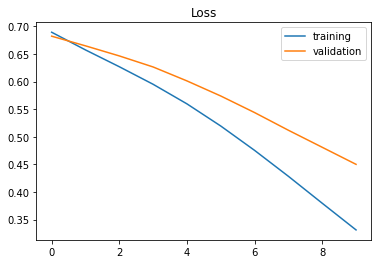

In [ ]:
# we will train for N epochs (The model will see the corpus N times)
EPOCHS = 10

# Learning rate is initially set to 0.5
LRATE = 0.5

# we define our embedding dimension (dimensionality of the output of the first layer)
EMBEDDING_DIM = 50

# dimensionality of the output of the second hidden layer
HIDDEN_DIM = 50

# the output dimension is the number of classes, 1 for binary classification
OUTPUT_DIM = 1

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), OUTPUT_DIM)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=LRATE)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.BCEWithLogitsLoss()

# Input and label tensors for training
feature_train = train_sent_tensor
target_train = train_label_tensor

# Input and label tensors for validation
feature_valid = valid_sent_tensor
target_valid = valid_label_tensor

# to ensure the dropout (explained later) is "turned on" while training
# good practice to include even if do not use here
model.train()
################
# Start training
################
training = []
validation = []
print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):  
  # we zero the gradients as they are not removed automatically
  optimizer.zero_grad()
  
  # squeeze is needed as the predictions will have the shape (batch size, 1)
  # and we need to remove the dimension of size 1
  predictions = model(feature_train).squeeze(1)

  # Compute the loss
  loss = loss_fn(predictions, target_train)
  train_loss = loss.item()

  # Compute training accuracy
  train_acc = accuracy(predictions, target_train)

  # calculate the gradient of each parameter
  loss.backward()

  # update the parameters using the gradients and optimizer algorithm 
  optimizer.step()
  
  # this puts the model in "evaluation mode" (turns off dropout and batch normalization)
  # good practise to include even if we do not use them right now
  model.eval()

  # we do not compute gradients within this block, i.e. no training
  with torch.no_grad():
    predictions_valid = model(feature_valid).squeeze(1)
    valid_loss = loss_fn(predictions_valid, target_valid).item()
    valid_acc = accuracy(predictions_valid, target_valid)
  training.append(train_loss)
  validation.append(valid_loss)
  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:6.2f}% |')
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(training,label='training')
plt.plot(validation,label='validation')
plt.legend()

### Testing the model

Now let us test our trained model. We define a small test set below. First, apply the data preparation procedures to this test set as you did for the validation set.


In [ ]:
test = ['i really do not like your short story', 
        'well done', 
        'good results for a study !',
        'amazing effort', 
        'your effort is poor !', 
        'not impressed'   
]

test_labels = [0, 1, 1, 1, 0, 0]

#########################################
# Q: Prepare the test corpus and labels #
tokenized_corpus_test = get_tokenized_corpus(test)
word2idx_test = get_word2idx(tokenized_corpus_test)
test_sent_tensor, test_label_tensor = get_model_inputs(tokenized_corpus_test, word2idx_test, test_labels)

print(test_sent_tensor)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10,  0,  0,  0,  0,  0,  0],
        [11, 12, 13, 14, 15, 16,  0,  0],
        [17, 18,  0,  0,  0,  0,  0,  0],
        [ 6, 18, 19, 20, 16,  0,  0,  0],
        [ 4, 21,  0,  0,  0,  0,  0,  0]])


**Q: Fill in the below function for the computation of F-measure. Once done, complete the missing lines in the final evaluation part.**

In [ ]:
def f_measure(output, gold):
  ############################################
  # Q: Compute precision, recall and f-measure 
  ############################################
  pred = torch.round(torch.sigmoid(output))

  pred = pred.detach().cpu().numpy()
  print(f'pred: {pred}')
  print(f'gold: {gold}')
  test_pos_preds = np.sum(pred)
  
  test_pos_real = np.sum(gold)
  #print((~np.logical_xor(pred, gold)).astype(int) )
  correct = (~np.logical_xor(pred, gold)).astype(int)
  
  correct = np.sum(correct)
  
  precision = correct / test_pos_preds
  recall = correct / test_pos_real
  
  fscore = (2.0 * precision * recall) / (precision + recall)

  # Print them
  print(f"     Recall: {recall:.2f}, Precision: {precision:.2f}, F-measure: {fscore:.2f}")
  

####

model.eval()

feature_test = test_sent_tensor
target_test = test_label_tensor

with torch.no_grad():
  ####################################################################
  # Q: Get predictions for the test set, compute the loss and accuracy
  ####################################################################
  predictions = model(feature_test).squeeze(1)
  
  test_loss = loss_fn(predictions, target_test).item()
  test_acc = accuracy(predictions, target_test)
  
  # Print
  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
  f_measure(predictions, test_labels)  

Test Loss: 1.043 | Test Acc: 16.67%
pred: [1. 0. 0. 1. 1. 1.]
gold: [0, 1, 1, 1, 0, 0]
     Recall: 0.33, Precision: 0.25, F-measure: 0.29


**Q:  Are the resulting evaluations different ? How do you interpret those differences? Print the predictions.**
 

## Model 2 : the Convolutional Neural Network (CNN)

We will implement a model inspired by the CNN model as described in [Convolutional Neural Networks for Sentence Classification (Kim, 2014)](https://arxiv.org/abs/1408.5882).

Similar to the FFNN model, we start with an embedding layer. We implement the convolutional layer with the help of `nn.Conv2d` and use the ReLU activation after it. The above-mentioned paper, being inspired by the convolution for images, applies a 2-dimensional convolution: a (window size, embedding dimension) filter. It covers `n` sequential words, taking embedding dimensions as the width. We then pass the tensors through a **max pooling layer**.

The **max pooling layer** is typically followed by a **dropout** layer. The latter sets a random set of activations in the max-pooling layer to zero. This prevents the network from learning to rely on specific weights and helps to prevent overfitting. Note that the dropout layer is only used during training, and not during test time.

---

**Q: Study the shapes of outputs coming from convolution and max pooling layers. What is the shape of the max pooling layer output?**

In [ ]:
class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout):
    super(CNN, self).__init__()
    
    # Create the embedding layer as usual
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    
    # in_channels -- 1 text channel
    # out_channels -- the number of output channels
    # kernel_size is (window size x embedding dim)
    self.conv = nn.Conv2d(
      in_channels=1, out_channels=out_channels,
      kernel_size=(window_size, embedding_dim))
    
    # the dropout layer
    self.dropout = nn.Dropout(dropout)

    # the output layer
    self.fc = nn.Linear(out_channels, output_dim)
        
  def forward(self, x):
    # x -> (batch size, max_sent_length)
    
    embedded = self.embedding(x)
    # embedded -> (batch size, max_sent_length, embedding_dim)
    
    # images have 3 RGB channels 
    # for the text we add 1 channel
    embedded = embedded.unsqueeze(1)
    # embedded -> (batch size, 1, max_sent_length, embedding dim)

    # Compute the feature maps      
    feature_maps = self.conv(embedded)

    ##########################################
    # Q: What is the shape of `feature_maps` ?
    ##########################################
    #(batch size, out_channels, max_sent_length - window_size + 1, 1).


    feature_maps = feature_maps.squeeze(3)
    
    ##########################################
    # Q: why do we remove 1 dimension here?
    ##########################################
    
    # Apply ReLU
    feature_maps = F.relu(feature_maps)
    
    # Apply the max pooling layer
    pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])
    
    pooled = pooled.squeeze(2)

    ####################################
    # Q: What is the shape of `pooled` ?
    ####################################
    #(batch size, out_channels, 1).
    dropped = self.dropout(pooled)
    preds = self.fc(dropped)
    
    return preds

### Training and testing the CNN

Here we will define the CNN-specific hyperparameters and perform the network training and testing. **Note that** the learning rate is initially set to 0.1.

Will train for 10 epochs
| Epoch: 01 | Train Loss: 0.766 | Train Acc:  50.00% | Val. Loss: 1.568 | Val. Acc:  50.00% |
| Epoch: 02 | Train Loss: 1.909 | Train Acc:  50.00% | Val. Loss: 3.850 | Val. Acc:  50.00% |
| Epoch: 03 | Train Loss: 4.695 | Train Acc:  50.00% | Val. Loss: 0.440 | Val. Acc:  66.67% |
| Epoch: 04 | Train Loss: 0.234 | Train Acc: 100.00% | Val. Loss: 0.361 | Val. Acc:  83.33% |
| Epoch: 05 | Train Loss: 0.235 | Train Acc:  90.00% | Val. Loss: 0.347 | Val. Acc:  66.67% |
| Epoch: 06 | Train Loss: 0.104 | Train Acc: 100.00% | Val. Loss: 0.264 | Val. Acc:  83.33% |
| Epoch: 07 | Train Loss: 0.083 | Train Acc: 100.00% | Val. Loss: 0.233 | Val. Acc: 100.00% |
| Epoch: 08 | Train Loss: 0.029 | Train Acc: 100.00% | Val. Loss: 0.220 | Val. Acc: 100.00% |
| Epoch: 09 | Train Loss: 0.028 | Train Acc: 100.00% | Val. Loss: 0.214 | Val. Acc: 100.00% |
| Epoch: 10 | Train Loss: 0.021 | Train Acc: 100.00% | Val. Loss: 0.211 | Val. Acc: 100.00% |
Test Loss: 1.999 | Test Acc: 50.00%

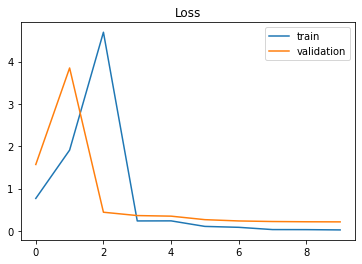

In [ ]:
fix_seed()

EPOCHS = 10
LRATE = 0.5

EMBEDDING_DIM = 50
OUTPUT_DIM = 1

# the hyperparameters specific to CNN
# we define the number of filters
N_OUT_CHANNELS = 100

# we define the window size
WINDOW_SIZE = 1

# we apply the dropout with the probability 0.2
DROPOUT = 0.2

# Construct the model
model = CNN(len(word2idx), EMBEDDING_DIM, N_OUT_CHANNELS, WINDOW_SIZE, OUTPUT_DIM, DROPOUT)

optimizer = optim.SGD(model.parameters(), lr=LRATE)
loss_fn = nn.BCEWithLogitsLoss()

feature_train = train_sent_tensor
target_train = train_label_tensor

feature_valid = valid_sent_tensor
target_valid = valid_label_tensor

feature_test = test_sent_tensor
target_test = test_label_tensor

################
# Start training
################
training = []
validation = []
print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):
  model.train()
  
  optimizer.zero_grad()

  predictions = model(feature_train).squeeze(1)
  loss = loss_fn(predictions, target_train)
  train_loss = loss.item()
  train_acc = accuracy(predictions, target_train)

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.no_grad():
    predictions_valid = model(feature_valid).squeeze(1)
    valid_loss = loss_fn(predictions_valid, target_valid).item()
    valid_acc = accuracy(predictions_valid, target_valid)
  training.append(train_loss)
  validation.append(valid_loss)
  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:6.2f}% |')


## Finally, test on the test set
model.eval()

with torch.no_grad():
    predictions = model(feature_test).squeeze(1)
    loss = loss_fn(predictions, target_test)
    acc = accuracy(predictions, target_test)
    print(f'Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
    f_measure(predictions, test_labels)

from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(training,label='train')
plt.plot(validation,label='validation')
plt.legend()

 **Q: Is the performance of CNN different from the performance of FFNN? Output predictions.**
 
**Q: Is padding necessary for CNN inputs? What is the role of the window size?**

### Initializing CNN with pre-trained representations

The work [Convolutional Neural Networks for Sentence Classification (Kim, 2014)](https://arxiv.org/abs/1408.5882) also investigates the exploitation of pre-trained embeddings and demonstrates the efficiency of using them.

First, download the embeddings and unzip them below:

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-03-29 10:25:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-29 10:25:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-29 10:25:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Unzip the file: 4 different embedding sizes are provided
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Check the file format
!head -n10 glove.6B.50d.txt

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0.42353


Try and initialize the CNN embedding layer with the `50D` pre-trained GloVe embeddings. Pay particular attention to keeping the correct indices from the `word2idx` for the lookup table! Once you fill the below `wvecs` matrix, copy the previous training loop and initialize its embedding layer with the pre-trained ones as follows:

```python
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))
```

**Note:** The learning rate is initially set to 0.5.

---

**Q: What should the embedding for the padding token `<pad>` be?**
 
**Q: What is the impact of using those pre-trained embeddings on the model performance?**

Loading GloVe embeddings: 100%|██████████| 400000/400000 [00:02<00:00, 163386.41it/s]


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0772915   0.0991575  -0.05334745 ... -0.37382796 -0.1733615
   0.5987865 ]
 [ 0.23925199  0.135421   -0.14507349 ... -0.43703398 -0.2581085
   0.1636895 ]
 ...
 [ 0.22531599  0.2587325   0.318305   ...  0.0562744   0.22124049
   0.88322   ]
 [-0.03108625 -0.0795405  -0.3636685  ...  0.2111525  -0.227305
   0.44012797]
 [-0.078585   -0.1093365   0.1566435  ...  0.0829075   0.04319965
   0.72559494]]
Will train for 20 epochs
| Epoch: 01 | Train Loss: 0.689 | Train Acc:  50.00% | Val. Loss: 0.668 | Val. Acc:  66.67% |
| Epoch: 02 | Train Loss: 0.619 | Train Acc: 100.00% | Val. Loss: 0.643 | Val. Acc:  66.67% |
| Epoch: 03 | Train Loss: 0.588 | Train Acc:  80.00% | Val. Loss: 0.620 | Val. Acc:  66.67% |
| Epoch: 04 | Train Loss: 0.548 | Train Acc:  90.00% | Val. Loss: 0.603 | Val. Acc:  66.67% |
| Epoch: 05 | Train Loss: 0.500 | Train Acc:  90.00% | Val. Loss: 0.579 | Val. Acc:  66.67% |
| Epoch: 06 | Train Loss:

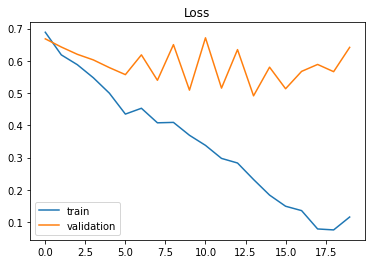

In [ ]:
from tqdm import tqdm

EMBEDDING_DIM = 50

# Yet another hyperparameter: since the pre-trained embeddings are coming
# from a different network, their magnitudes could differ from the parameters
# of this network. So scaling may be necessary.
SCALE_EMBS = 0.65

# Creates the empty numpy array that you should fill below
wvecs = np.zeros((len(word2idx), EMBEDDING_DIM), dtype='float32')

#####################################################################
# Q: Read line by line, find the corresponding word and
# insert its embedding to the correct position in the `wvecs` matrix.
# Once done, apply the SCALE_EMBS factor to scale the vectors
#####################################################################
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', 'r') as f:
    for line in tqdm(f, desc="Loading GloVe embeddings", total=400000):
        values = line.split()
        word = values[0]
        if word in word2idx:
            idx = word2idx[word]
            coefs = np.asarray(values[1:], dtype='float32')
            coefs *= SCALE_EMBS
            wvecs[idx] = coefs

            
print(wvecs)


#####################
# Re-create the model
#####################
fix_seed()

EPOCHS = 20
LRATE = 0.5

# the hyperparameters specific to CNN
OUTPUT_DIM = 1

# we define the number of filters
N_OUT_CHANNELS = 100

# we define the window size
WINDOW_SIZE = 1

# we apply the dropout with the probability 0.1
DROPOUT = 0.2

# Construct the model
model = CNN(len(word2idx), EMBEDDING_DIM, N_OUT_CHANNELS, WINDOW_SIZE, OUTPUT_DIM, DROPOUT)

#################################################################
### Q: Initialize the embeddings with the loaded pre-trained ones
#################################################################
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

optimizer = optim.SGD(model.parameters(), lr=LRATE)
loss_fn = nn.BCEWithLogitsLoss()

feature_train = train_sent_tensor
target_train = train_label_tensor

feature_valid = valid_sent_tensor
target_valid = valid_label_tensor

feature_test = test_sent_tensor
target_test = test_label_tensor

################
# Start training
################
training = []
validation = []
print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):
  model.train()
  
  optimizer.zero_grad()

  predictions = model(feature_train).squeeze(1)
  loss = loss_fn(predictions, target_train)
  train_loss = loss.item()
  train_acc = accuracy(predictions, target_train)

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.no_grad():
    predictions_valid = model(feature_valid).squeeze(1)
    valid_loss = loss_fn(predictions_valid, target_valid).item()
    valid_acc = accuracy(predictions_valid, target_valid)
  training.append(train_loss)
  validation.append(valid_loss)
  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:6.2f}% |')

## Finally, test on the test set
model.eval()

with torch.no_grad():
    predictions = model(feature_test).squeeze(1)
    loss = loss_fn(predictions, target_test)
    acc = accuracy(predictions, target_test)
    print(f'Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')
    f_measure(predictions, test_labels)
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(training,label='train')
plt.plot(validation,label='validation')
plt.legend()
